## Model Selection and hyperparameters tunning

### Análisis de Sentimiento para Mejorar Estrategias de Estreno de Películas  

Una productora cinematográfica está evaluando el sentimiento en las reseñas de las películas que estrenó recientemente para ajustar sus estrategias de promoción y distribución en futuras producciones. Las reseñas en línea, publicadas por los espectadores en plataformas como *IMDb*, *Rotten Tomatoes*, *Letterboxd* y redes sociales, reflejan cómo la audiencia percibe cada película. Analizar estas opiniones permitiría a la productora identificar patrones de percepción y tomar decisiones estratégicas para futuras producciones.  

El análisis de sentimiento se aplicaría para clasificar automáticamente las reseñas de los espectadores como positivas o negativas, con el objetivo de detectar patrones recurrentes en la percepción de temas, actores, tramas o estilos de dirección, evaluar el impacto de la estrategia publicitaria y optimizar las campañas de marketing. Con esta información, la productora podría rediseñar sus estrategias publicitarias, elegir mejores plataformas de estreno, establecer alianzas estratégicas y crear experiencias adicionales para los fans, como eventos y promociones.  

De esta manera, la clasificación automática de reseñas no solo funcionaría como un diagnóstico de la percepción de los espectadores, sino también como una herramienta estratégica para reforzar la calidad, el marketing y el éxito de las futuras producciones. Esta implementación permitiría una mejor comprensión de las opiniones de los espectadores, la optimización de la inversión publicitaria y el fortalecimiento de la relación con la audiencia.


### Load and prepare data

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import re
import string

# Text processing and analysis
from nltk.corpus import stopwords

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

In [2]:
df = pd.read_csv('data/IMDB Dataset.csv')  
df.sample(10)

,review,sentiment
35360,A grade-Z horror filmmaker Carl Monson was one...,negative
35724,"I agree with ""Jerry."" It's a very underrated s...",positive
28157,This sounded like a really interesting movie f...,negative
45232,I am a massive fan of the book and Orwell is c...,negative
49981,"And I repeat, please do not see this movie! Th...",negative
13178,Enjoyable in spite of Leslie Howard's performa...,positive
14754,Sure it is a new take on vampires. Who cares. ...,negative
14737,A friend of mine who has a mysterious knack fo...,negative
4416,The only thing I expected that this film didn'...,negative
35626,Unfortunately there was not a 0 for a rating o...,negative


Search for missing and duplicated entries

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [4]:
df.isnull().sum()

review       0
sentiment    0
dtype: int64

In [5]:
df.duplicated().sum()

418

In [6]:
df = df.drop_duplicates()

Classes distribution

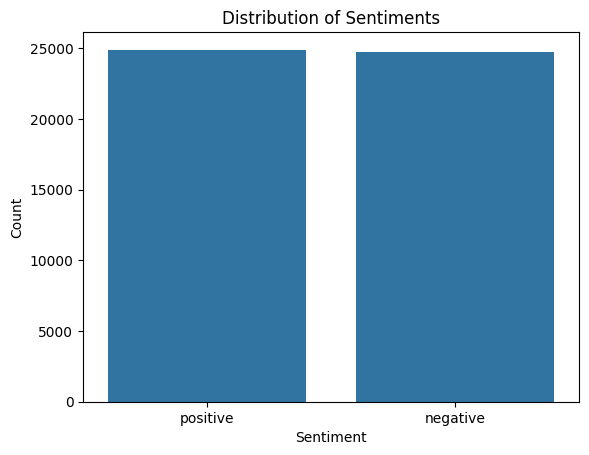

In [7]:
# Distribution of sentiments
sns.countplot(x='sentiment', data=df)
plt.title('Distribution of Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

Length of the reviews

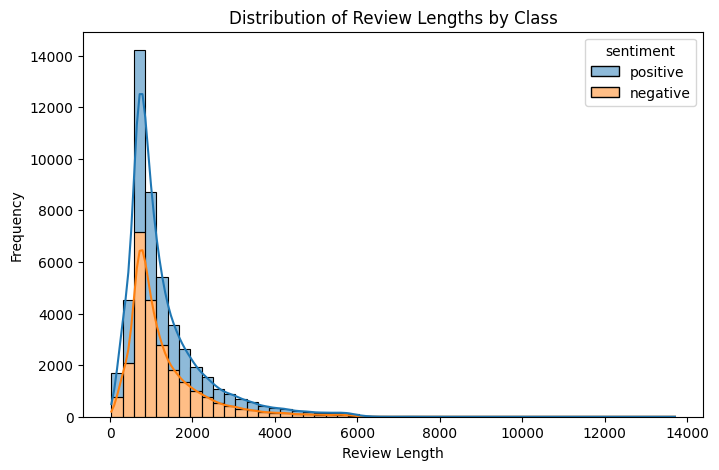

In [8]:
# Add a column for review length
df['review_length'] = df['review'].apply(len)

# Plot the distribution of review lengths across each class (positive and negative)
plt.figure(figsize=(8, 5))
sns.histplot(data=df, x='review_length', hue='sentiment', multiple='stack', bins=50, kde=True)
plt.title('Distribution of Review Lengths by Class')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.show()

Word Cloud for positive and negative reviews

(-0.5, 399.5, 299.5, -0.5)

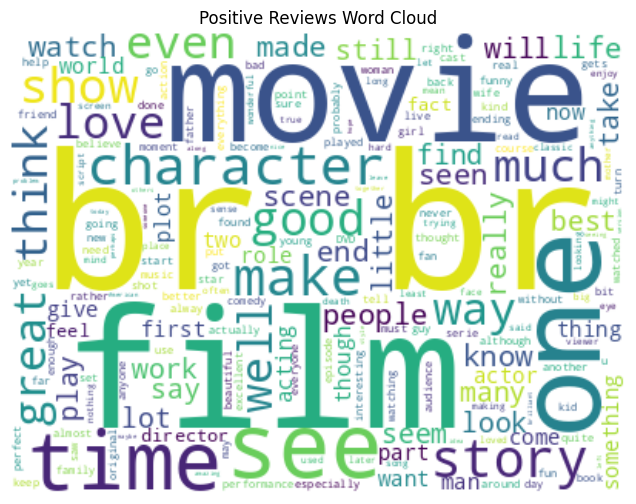

In [9]:
from wordcloud import WordCloud

# Separate positive and negative reviews
positive_reviews = " ".join(df[df['sentiment'] == 'positive']['review'])

# Positive reviews word cloud
plt.figure(figsize=(12, 6))
wordcloud_positive = WordCloud(width=400, height=300, background_color='white').generate(positive_reviews)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Positive Reviews Word Cloud')
plt.axis('off')

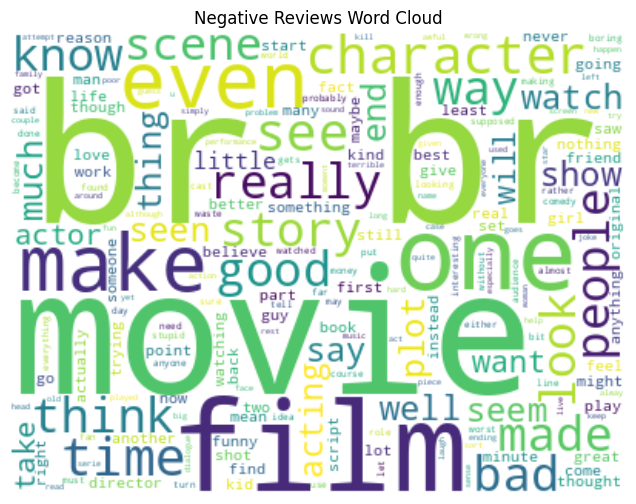

In [10]:
negative_reviews = " ".join(df[df['sentiment'] == 'negative']['review'])
# Negative reviews word cloud
plt.figure(figsize=(12, 6))
wordcloud_negative = WordCloud(width=400, height=300, background_color='white').generate(negative_reviews)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Negative Reviews Word Cloud')
plt.axis('off')

plt.show()

#### Text preprocessing

In [11]:
# remove tags 
def remove_tag(text):
    pattren = re.compile('<[^>]+>')
    return pattren.sub(r'', text)

# remove URLs 
def remove_urls(text):
    pattren = re.compile(r'\b(?:https?|ftp|www)\S+\b')
    return pattren.sub(r'', text)

# Function to remove stopwords
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    new_text = [word for word in text.split() if word not in stop_words]
    return ' '.join(new_text)

# remove punctuation from discription column;
puncuations = string.punctuation
exclude = puncuations
def remove_punc(text):
    for char in exclude:
        text = text.replace(char, '')
        return text

In [12]:
df['review'] = df['review'].str.lower()
df['review'] = df['review'].apply(remove_tag)
df['review'] = df['review'].apply(remove_urls)
df['review'] = df['review'].apply(remove_stopwords)
df['review'] = df['review'].apply(remove_punc)

Las **stop words** son palabras como *"and"*, *"the"*, *"him"*, que se consideran no informativas para representar el contenido de un texto y pueden ser eliminadas para evitar que se interpreten como señales en tareas de predicción.  

Sin embargo, en algunos casos, palabras similares pueden ser útiles para la predicción, por ejemplo, en la clasificación de estilos de escritura o personalidad.  

Es importante tener cuidado al elegir una lista de **stop words**.  
Las listas más populares pueden incluir palabras que son altamente informativas para ciertas tareas, como la palabra *computer*.  

También debe asegurarse de que la lista de **stop words** haya sido preprocesada y tokenizada de la misma manera que el vectorizador utilizado.  

Por ejemplo, la palabra *"we've"* se divide en *"we"* y *"ve"* mediante el tokenizador por defecto de **CountVectorizer**, por lo que si *"we've"* está en `stop_words`, pero *"ve"* no lo está, *"ve"* se mantendrá en el texto transformado.  


### **ML models**

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

#### **Logistic Regression**

In [14]:
# Splitting data
X = df['review']
y = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)  # Adjust sentiment label as needed
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Create the pipeline
- **Feature selection**
- Model selection

**Feature selection** 

Al elegir una estrategia de vectorización, es importante considerar la naturaleza de la tarea, la complejidad del modelo y la información que necesitamos capturar para distinguir entre reseñas positivas y negativas.

Algunas estrategias podrían ser:

**1. Bag of Words (BoW)** 

*¿Qué es?*

El modelo de **Bag of Words (BoW)** representa el texto como una matriz de frecuencia de palabras, donde cada fila es un documento (reseña de película) y cada columna es una palabra del vocabulario. El valor de cada celda es el número de veces que una palabra aparece en el documento.  

*Ventajas*
- Simplicidad y rapidez de implementación.  
  Es un modelo fácil de implementar y muy eficiente computacionalmente.  
- Ideal para datasets pequeños y problemas simples. 
  Si las reseñas tienen un vocabulario relativamente pequeño, este enfoque puede ser efectivo.  

*Desventajas*  
- Ignora el contexto de las palabras. 
  Palabras con significados diferentes según el contexto (por ejemplo, *"no bueno"* vs. *"bueno"*) se tratan como independientes. Una alternativa para mejorar esto sería usar bigramas. 
- Vocabulario grande para textos complejos.
  Si las reseñas son variadas, el tamaño del vocabulario puede crecer rápidamente, ocasionando una matriz muy dispersa y difícil de manejar.  
- No captura relaciones semánticas. 

**2. TF-IDF (Term Frequency-Inverse Document Frequency)**  

*¿Qué es?* 
El método **TF-IDF** ajusta la frecuencia de una palabra en un documento considerando su frecuencia en todo el corpus. Así, las palabras que son comunes en la mayoría de los documentos tienen un peso bajo, mientras que las palabras que son más específicas en algunos textos tienen un peso mayor.  

*Ventajas*
- Captura palabras informativas. 
  A diferencia de BoW, TF-IDF asigna menor peso a palabras muy comunes en todo el conjunto de datos, lo que puede destacar palabras con mayor poder discriminativo para la clasificación.  

*Desventajas* 
- Todavía ignora el contexto semántico.
  No tiene en cuenta relaciones complejas entre palabras que pueden ser importantes para el análisis de sentimiento.  
- Puede resultar insuficiente si el vocabulario es grande. 

**3. Embeddings** 

*¿Qué es?*  

Los **embeddings** convierten las palabras en vectores densos que capturan la relación semántica entre ellas. A diferencia de Bag of Words y TF-IDF, los embeddings comprenden la relación entre palabras, incluso si no aparecen exactamente en los textos de entrenamiento.  

*Ventajas*  
- Captura relaciones semánticas y contexto.
  Por ejemplo, las palabras *"bueno"* y *"positivo"* tendrán vectores similares porque comparten significado.  
- Son transferibles y poderosos para ML.
  Los embeddings preentrenados como Word2Vec, GloVe o BERT pueden ser cargados directamente, reduciendo la necesidad de grandes cantidades de datos para entrenar.  
- Adecuados para tareas complejas como clasificación de sentimientos. 

*Desventajas* 
- Requieren más recursos computacionales.
  Procesar embeddings es más costoso en términos de tiempo y memoria.  
- Dependencia de embeddings preentrenados.  
  Si los embeddings utilizados no se ajustan bien al contexto específico de las reseñas de películas en tu tarea, pueden tener un impacto negativo. 




| **Enfoque**       | **Ventajas**                                                                 | **Desventajas**                                                                 |
|--------------------|----------------------------------------------------------------------------|----------------------------------------------------------------------------------|
| **Bag of Words**   | Sencillo, rápido, eficiente en vocabularios pequeños.                       | Ignora el contexto, no captura relaciones semánticas, vocabulario grande.      |
| **TF-IDF**         | Más preciso que BoW, enfocado en palabras informativas.                     | Todavía limitado semánticamente, puede ser insuficiente en contextos complejos. |
| **Embeddings**     | Captura relaciones semánticas, contextuales y es transferible.               | Requiere más recursos computacionales y dependencia de embeddings preentrenados. |
 

La elección del vectorizador dependerá del contexto, los recursos y la cantidad de datos disponibles. Sin embargo, **la experimentación será clave para determinar cuál enfoque es el más efectivo en este caso particular.**  
Cada método tiene sus fortalezas y limitaciones, y solo al probarlos en tu conjunto de datos podrás identificar el mejor enfoque para clasificar las reseñas de películas como positivas o negativas.


In [22]:
from w2v_trasformer import Word2VecTransformer
import gensim.downloader as api

# Bag-of-Words Pipeline
bow_pipeline_lr = Pipeline([
    ('vectorizer', CountVectorizer(max_features=10000, stop_words='english', ngram_range=(2, 2))),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

# TF-IDF Pipeline
tfidf_pipeline_lr = Pipeline([
    ('vectorizer', TfidfVectorizer(max_features=10000, stop_words='english')),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

# Word2Vec Pipeline
word2vec_model = api.load("glove-wiki-gigaword-100")
word2vec_pipeline_lr = Pipeline([
    ('word2vec', Word2VecTransformer(word2vec_model, vector_size=100)),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

# Define pipelines with labels
pipelines = {
    "BoW + Logistic Regression": bow_pipeline_lr,
    "TF-IDF + Logistic Regression": tfidf_pipeline_lr,
    "Word2Vec + Logistic Regression": word2vec_pipeline_lr
}

##### Evaluate each pipeline

In [16]:
metrics_results = {}

for name, pipeline in pipelines.items():
    
    print(f"Evaluating: {name}")
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_train)
    y_pred_proba = pipeline.predict_proba(X_train)[:, 1] if hasattr(pipeline['classifier'], "predict_proba") else None
    
    # Store classification report
    report = classification_report(y_train, y_pred, output_dict=True)
    metrics_results[name] = report
    
    # Store ROC curve metrics if probability scores are available
    if y_pred_proba is not None:
        fpr, tpr, _ = roc_curve(y_train, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        metrics_results[name]['roc_curve'] = (fpr, tpr, roc_auc)


Evaluating: BoW + Logistic Regression
Evaluating: TF-IDF + Logistic Regression
Evaluating: Word2Vec + Logistic Regression


In [ ]:
# Prepare data for metrics visualization
metrics_df = pd.DataFrame([
    {
        'Pipeline': name,
        'Precision': report['weighted avg']['precision'],
        'Recall': report['weighted avg']['recall'],
        'F1-score': report['weighted avg']['f1-score'],
        'ROC AUC': report['roc_curve'][2] if 'roc_curve' in report else None
    }
    for name, report in metrics_results.items()
])
metrics_df

,Pipeline,Precision,Recall,F1-score,ROC AUC
0,BoW + Logistic Regression,0.975523,0.975520,0.975520,0.996762
1,TF-IDF + Logistic Regression,0.921762,0.921593,0.921582,0.976294
2,Word2Vec + Logistic Regression,0.785390,0.785378,0.785378,0.864218


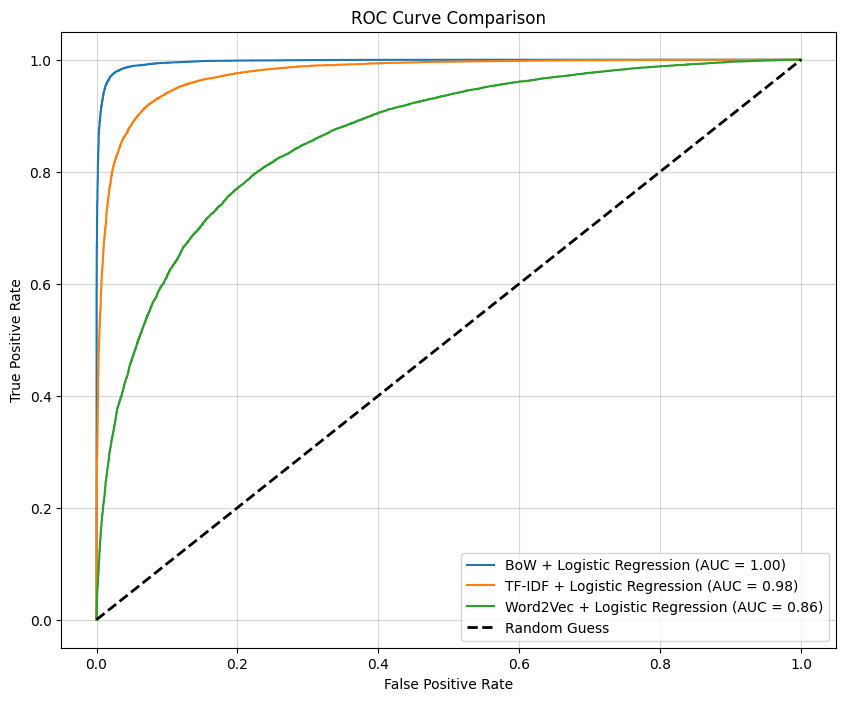

In [ ]:
# Plot ROC Curves
plt.figure(figsize=(10, 8))

for name, result in metrics_results.items():
    if 'roc_curve' in result:
        fpr, tpr, roc_auc = result['roc_curve']
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

# Add diagonal line for random guess
plt.plot([0, 1], [0, 1], 'k--', lw=2, label="Random Guess")

# Formatting
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')
plt.grid(alpha=0.5)
plt.show()

Hagamos ahora una estimación del desempeño real de nuestro modelo usando validacion cruzada.

Primero, asegúrate de volver a inicializar los modelos con sus pesos originales.  

Evaluating pipeline: BoW + Logistic Regression
Evaluating pipeline: TF-IDF + Logistic Regression
Evaluating pipeline: Word2Vec + Logistic Regression


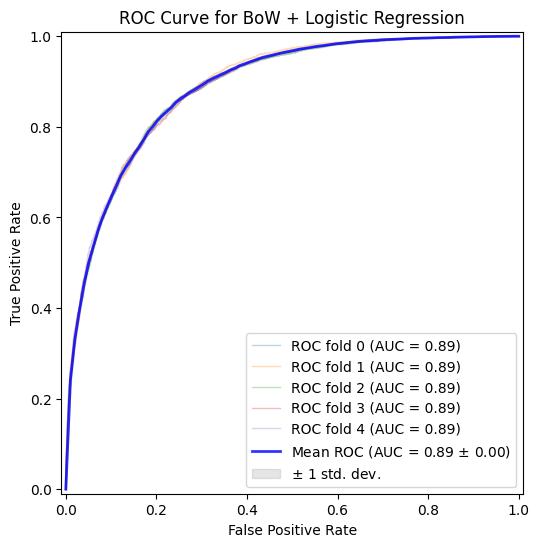

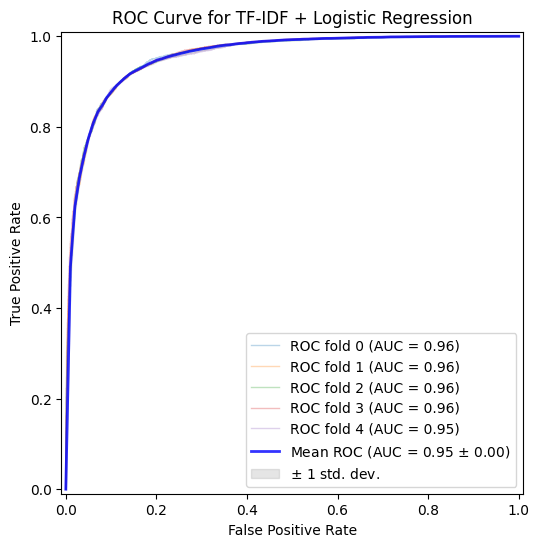

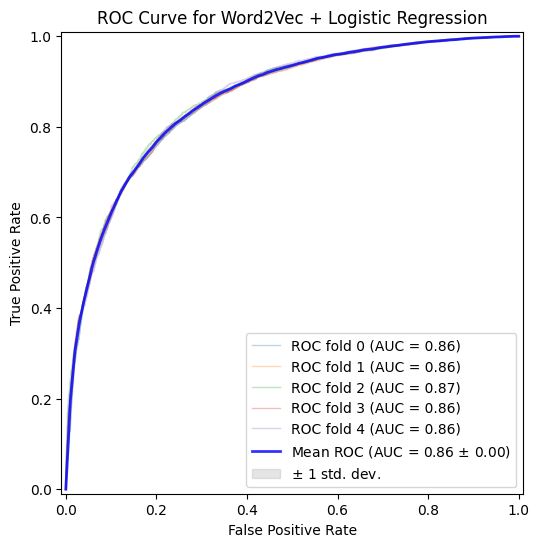

In [23]:
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import RocCurveDisplay, auc
import numpy as np

# Stratified K-Fold Cross Validation
n_splits = 5
cv = StratifiedKFold(n_splits=n_splits)
mean_fpr = np.linspace(0, 1, 100)

# Storage for ROC plots and cross-validation results
pipeline_results = {}

scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision_weighted',
    'recall': 'recall_weighted',
    'f1': 'f1_weighted',
    'roc_auc': 'roc_auc',
}

# Storage for plots
pipeline_roc_plots = []

for name, pipeline in pipelines.items():
    print(f"Evaluating pipeline: {name}")
    
    tprs = []
    aucs = []
    fig, ax = plt.subplots(figsize=(6, 6))

    # Cross-validation and ROC curve computation
    fold_cv_results = cross_validate(
        pipeline,
        X_train,
        y_train,
        scoring=scoring,
        cv=cv,
        return_train_score=True,
    )

    results = {key: np.mean(value) for key, value in fold_cv_results.items()}

    
    for fold, (train, test) in enumerate(cv.split(X_train, y_train)):
        
        pipeline.fit(X_train.iloc[train], y_train.iloc[train])
        
        # Generate the ROC curve for the current fold
        viz = RocCurveDisplay.from_estimator(
            pipeline,
            X_train.iloc[test],
            y_train.iloc[test],
            name=f"ROC fold {fold}",
            alpha=0.3,
            lw=1,
            ax=ax,
        )
        
        # Interpolate TPR and calculate AUC
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)
    
    # Calculate mean and std for TPR
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    
    # Plot the mean ROC curve
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )
    
    # Plot variability
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )
    
    # Set plot details
    ax.set(
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title=f"ROC Curve for {name}",
    )
    ax.legend(loc="lower right")
    
    # Store results
    pipeline_results[name] = {
        'cv_results': results,
        'roc_curve': fig,
    }

In [25]:
pd.DataFrame(pipeline_results[item]['cv_results'] for item in pipeline_results.keys())

,fit_time,score_time,test_accuracy,train_accuracy,test_precision,train_precision,test_recall,train_recall,test_f1,train_f1,test_roc_auc,train_roc_auc
0,19.945327,2.854409,0.805647,0.931653,0.805910,0.931904,0.805647,0.931653,0.805592,0.931639,0.888322,0.983511
1,5.301203,2.356799,0.889071,0.922759,0.889409,0.922939,0.889071,0.922759,0.889040,0.922748,0.955922,0.976698
2,11.887972,5.873945,0.783688,0.785667,0.783713,0.785680,0.783688,0.785667,0.783687,0.785668,0.862135,0.864340


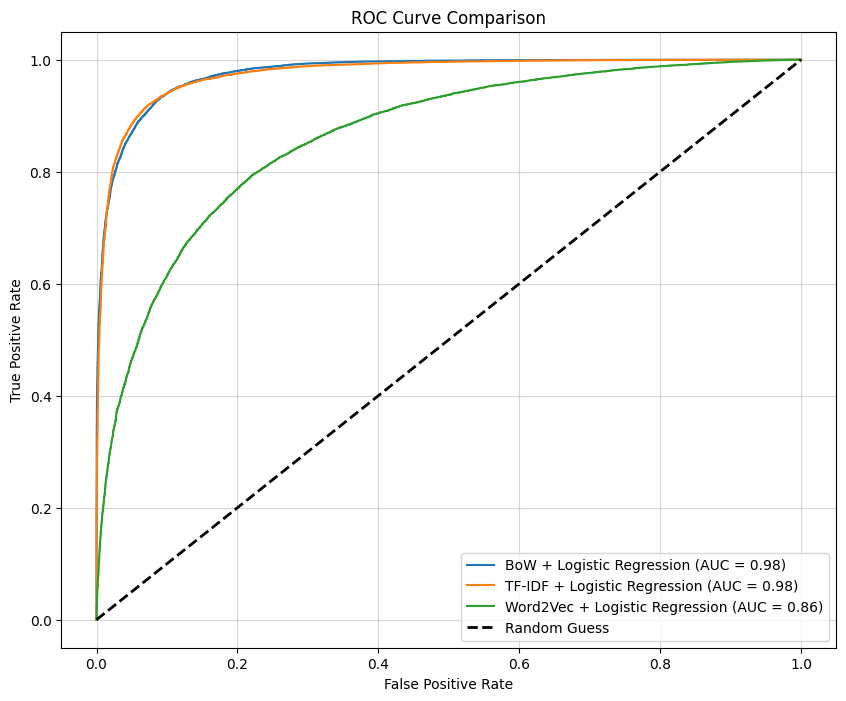

In [27]:
# Plot ROC Curves
plt.figure(figsize=(10, 8))

for name, result in metrics_results.items():
    if 'roc_curve' in result:
        fpr, tpr, roc_auc = result['roc_curve']
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

# Add diagonal line for random guess
plt.plot([0, 1], [0, 1], 'k--', lw=2, label="Random Guess")

# Formatting
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')
plt.grid(alpha=0.5)
plt.show()

Cuál modelo parece ser el que mejores resultados da? 

Ajustemos el del vectorizador *TF-IDF*!!

In [28]:
from sklearn.model_selection import validation_curve
import numpy as np
param_name, param_range = "classifier__C", np.logspace(-8, 3, 10)
train_scores, test_scores = validation_curve(
    tfidf_pipeline_lr, X_train, y_train, param_name=param_name, param_range=param_range
)


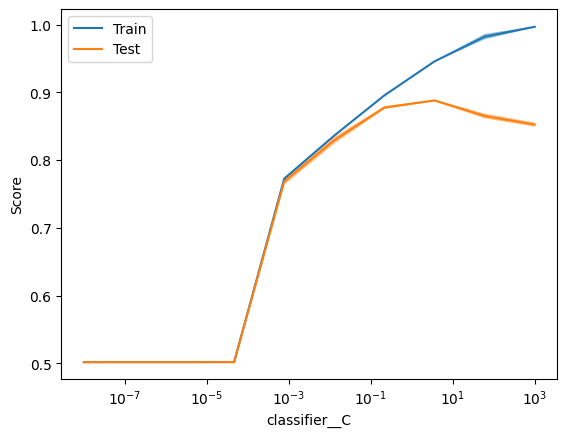

In [29]:
from sklearn.model_selection import ValidationCurveDisplay
display = ValidationCurveDisplay(
    param_name = param_name, param_range=param_range,
    train_scores=train_scores, test_scores=test_scores, score_name="Score"
)
display.plot()
plt.show()

In [30]:
tfidf_pipeline_lr.set_params(classifier__C = 10**(-1))
result = cross_validate(
            tfidf_pipeline_lr, X_train, y_train,
            scoring=scoring,
            cv=5,  # 5-fold cross-validation
            return_train_score=True
        )

In [31]:
pd.DataFrame(result).T

,0,1,2,3,4
fit_time,6.875539,6.753496,4.793415,4.792483,4.628959
score_time,2.197006,2.350455,2.191924,2.237728,2.185195
test_accuracy,0.872936,0.867515,0.863230,0.867137,0.861591
train_accuracy,0.879239,0.880373,0.880058,0.880972,0.881728
test_precision,0.873808,0.869181,0.864825,0.868413,0.863238
train_precision,0.880427,0.881544,0.881326,0.882196,0.882934
test_recall,0.872936,0.867515,0.863230,0.867137,0.861591
train_recall,0.879239,0.880373,0.880058,0.880972,0.881728
test_f1,0.872848,0.867346,0.863060,0.867005,0.861412
train_f1,0.879130,0.880267,0.879943,0.880862,0.881621


Entrenemos finalmente el modelo escogido con los hiperparámetros y evaluemoslo en el conjunto de evaluación.

In [32]:
tfidf_pipeline_lr.fit(X_train, y_train)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_features=10000, stop_words='english')),
                ('classifier',
                 LogisticRegression(C=0.1, max_iter=1000, random_state=42))])

In [33]:
y_pred = tfidf_pipeline_lr.predict(X_test)
report = classification_report(y_test, y_pred, output_dict=True)
pd.DataFrame(report)


,0,1,accuracy,macro avg,weighted avg
precision,0.890467,0.848008,0.867904,0.869237,0.869154
recall,0.837821,0.897750,0.867904,0.867786,0.867904
f1-score,0.863342,0.872170,0.867904,0.867756,0.867774
support,4939.000000,4978.000000,0.867904,9917.000000,9917.000000
